In [41]:
import numpy as np
import pandas as pd
import sympy as sp
import matplotlib.pyplot as plt

from math import cos, sin, cosh, sinh, sqrt, pi

In [42]:
class OneDOptimizer:
    def __init__(self, func, a, b, delta=1e-6):
        self.func = func
        self.a = a
        self.b = b
        self.delta = delta
        self.func_calls = 0
        self.iterations = 0

    def evaluate(self, x):
        self.func_calls += 1
        return self.func(x)

    def golden_section(self):
        self.func_calls = 0
        self.iterations = 0
        a, b = self.a, self.b
        phi = (sqrt(5) - 1) / 2.0

        x1 = b - phi * (b - a)
        x2 = a + phi * (b - a)
        f1 = self.evaluate(x1)
        f2 = self.evaluate(x2)

        while (b - a) > self.delta:
            self.iterations += 1
            if f1 < f2:
                b = x2
                x2 = x1
                f2 = f1
                x1 = b - phi * (b - a)
                f1 = self.evaluate(x1)
            else:
                a = x1
                x1 = x2
                f1 = f2
                x2 = a + phi * (b - a)
                f2 = self.evaluate(x2)

        x_min = (a + b) / 2.0
        f_min = self.evaluate(x_min)
        return x_min, f_min, self.iterations, self.func_calls


In [43]:
class TargetFunction:
    def __init__(self, x0=0.0, z0=3.0, alpha=pi/3.0):
        self.x0 = float(x0)
        self.z0 = float(z0)
        self.alpha = float(alpha)
        self.c = cos(self.alpha)
        self.s = sin(self.alpha)

    def _uv(self, x, y, z):
        """Вычисляем u=x' и v=z' (координаты в повернутой-смещённой системе)"""
        dx = x - self.x0
        dz = z - self.z0
        u = self.c * dx + self.s * dz
        v = -self.s * dx + self.c * dz
        return u, v

    def value(self, X):
        x, y, z = float(X[0]), float(X[1]), float(X[2])
        u, v = self._uv(x, y, z)
        return u**4 + cosh(y - 1.0) + v**2

    def gradient(self, X):
        x, y, z = float(X[0]), float(X[1]), float(X[2])
        u, v = self._uv(x, y, z)
        c, s = self.c, self.s

        df_dx = 4.0 * (u**3) * c + 2.0 * v * (-s)
        df_dy = sinh(y - 1.0)
        df_dz = 4.0 * (u**3) * s + 2.0 * v * c
        return np.array([df_dx, df_dy, df_dz], dtype=float)

    def hessian(self, X):
        x, y, z = float(X[0]), float(X[1]), float(X[2])
        u, v = self._uv(x, y, z)
        c, s = self.c, self.s

        dxx = 12.0 * (u**2) * (c**2) + 2.0 * (s**2)
        dzz = 12.0 * (u**2) * (s**2) + 2.0 * (c**2)
        dxz = c * s * (12.0 * (u**2) - 2.0)
        dyy = cosh(y - 1.0)

        H = np.array([
            [dxx, 0.0, dxz],
            [0.0, dyy, 0.0],
            [dxz, 0.0, dzz]
        ], dtype=float)
        return H


In [44]:
def line_search_along_direction(func3d, xk, d, bracket=(-10.0, 10.0), delta=1e-6):
    """
    func3d: объект TargetFunction (с методом value)
    xk: точка (3,)
    d: направление (3,)
    возвращает оптимальный alpha (скаляр) и значение функции
    """
    def phi(alpha):
        X = xk + alpha * d
        return func3d.value(X)

    one_d = OneDOptimizer(phi, bracket[0], bracket[1], delta=delta)
    alpha_opt, f_min, iters, calls = one_d.golden_section()
    return alpha_opt, f_min, iters, calls


In [45]:
def coordinate_descent(func3d, x0, tol=1e-6, max_iters=500, line_bracket=(-10,10)):
    xk = np.array(x0, dtype=float)
    n = 3
    history = []
    total_line_calls = 0
    total_line_iters = 0

    for k in range(max_iters):
        x_prev = xk.copy()
        for i in range(n):
            ei = np.zeros(3)
            ei[i] = 1.0
            alpha, fmin, iters, calls = line_search_along_direction(func3d, xk, ei, bracket=line_bracket, delta=tol/10.0)
            total_line_calls += calls
            total_line_iters += iters
            xk = xk + alpha * ei
        grad_norm = np.linalg.norm(func3d.gradient(xk))
        history.append((k+1, xk.copy(), func3d.value(xk), grad_norm))
        if grad_norm < tol and np.linalg.norm(xk - x_prev) < tol:
            break
    return {
        'method': 'Координатный спуск',
        'x_min': xk,
        'f_min': func3d.value(xk),
        'iterations': len(history),
        'grad_norm': grad_norm,
        'line_search_calls': total_line_calls,
        'line_search_iters': total_line_iters,
        'history': history
    }

def steepest_descent(func3d, x0, tol=1e-6, max_iters=500, line_bracket=(-10,10)):
    xk = np.array(x0, dtype=float)
    history = []
    total_line_calls = 0
    total_line_iters = 0

    for k in range(max_iters):
        gk = func3d.gradient(xk)
        grad_norm = np.linalg.norm(gk)
        history.append((k+1, xk.copy(), func3d.value(xk), grad_norm))
        if grad_norm < tol:
            break
        dk = -gk
        alpha, fmin, iters, calls = line_search_along_direction(func3d, xk, dk, bracket=line_bracket, delta=tol/10.0)
        total_line_calls += calls
        total_line_iters += iters
        xk = xk + alpha * dk
    return {
        'method': 'Наискорейший спуск',
        'x_min': xk,
        'f_min': func3d.value(xk),
        'iterations': len(history),
        'grad_norm': np.linalg.norm(func3d.gradient(xk)),
        'line_search_calls': total_line_calls,
        'line_search_iters': total_line_iters,
        'history': history
    }

def newton_method(func3d, x0, tol=1e-6, max_iters=100):
    xk = np.array(x0, dtype=float)
    history = []
    for k in range(max_iters):
        gk = func3d.gradient(xk)
        grad_norm = np.linalg.norm(gk)
        history.append((k+1, xk.copy(), func3d.value(xk), grad_norm))
        if grad_norm < tol:
            break
        Hk = func3d.hessian(xk)
        try:
            pk = np.linalg.solve(Hk, -gk)
        except np.linalg.LinAlgError:
            pk = -gk
        xk = xk + 1.0 * pk
    return {
        'method': 'Метод Ньютона',
        'x_min': xk,
        'f_min': func3d.value(xk),
        'iterations': len(history),
        'grad_norm': np.linalg.norm(func3d.gradient(xk)),
        'history': history
    }

In [46]:
def plot_function_surface():
    from mpl_toolkits.mplot3d import Axes3D

    func3d = TargetFunction(x0=0, z0=3, alpha=pi/3)

    x_vals = np.linspace(-4, 4, 100)
    z_vals = np.linspace(0, 6, 100)
    X, Z = np.meshgrid(x_vals, z_vals)
    Y = np.ones_like(X)

    F = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            F[i, j] = func3d.value([X[i, j], Y[i, j], Z[i, j]])

    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Z, F, cmap='viridis', edgecolor='none', alpha=0.9)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('f(x, y=1, z)')
    ax.set_title('Поверхность функции при y = 1')
    fig.colorbar(surf, shrink=0.6, aspect=10)

    ax.scatter(0, 3, func3d.value([0,1,3]), color='r', s=50, label='Минимум (0,1,3)')
    ax.legend()

    plt.show()

In [47]:
def analytical_solution_sympy():
    print("=== АНАЛИТИЧЕСКОЕ РЕШЕНИЕ С ПОМОЩЬЮ SYMPY ===")

    x, y, z = sp.symbols('x y z', real=True)
    alpha = sp.pi / 3
    x0, z0 = 0, 3

    u = sp.cos(alpha) * (x - x0) + sp.sin(alpha) * (z - z0)
    v = -sp.sin(alpha) * (x - x0) + sp.cos(alpha) * (z - z0)

    f = u**4 + sp.cosh(y - 1) + v**2
    print(f"Функция:\n  f(x,y,z) = {f}\n")

    grad = [sp.diff(f, var) for var in (x, y, z)]
    print("Градиент f'(x,y,z):")
    for var, g in zip((x, y, z), grad):
        print(f"  d/d{var} = {sp.simplify(g)}")

    print("\nРешаем систему grad(f)=0 ...")
    sol = sp.solve(grad, (x, y, z), dict=True)

    if sol:
        for s in sol:
            print(f"→ Решение: {s}")
    else:
        print("Решений не найдено аналитически (проверьте выражение).")

    x_min, y_min, z_min = 0, 1, 3
    f_min = f.subs({x: x_min, y: y_min, z: z_min})
    print(f"\nМинимум функции достигается в точке:")
    print(f"  x = {x_min}, y = {y_min}, z = {z_min}")
    print(f"  f(x,y,z) = {sp.N(f_min):.10f}\n")

    return (x_min, y_min, z_min), float(sp.N(f_min))

=== АНАЛИТИЧЕСКОЕ РЕШЕНИЕ С ПОМОЩЬЮ SYMPY ===
Функция:
  f(x,y,z) = (x/2 + sqrt(3)*(z - 3)/2)**4 + (-sqrt(3)*x/2 + z/2 - 3/2)**2 + cosh(y - 1)

Градиент f'(x,y,z):
  d/dx = (x + sqrt(3)*(z - 3))**3/4 + sqrt(3)*(sqrt(3)*x - z + 3)/2
  d/dy = sinh(y - 1)
  d/dz = -sqrt(3)*x/2 + z/2 + sqrt(3)*(x + sqrt(3)*(z - 3))**3/4 - 3/2

Решаем систему grad(f)=0 ...
→ Решение: {x: 0, y: 1, z: 3}

Минимум функции достигается в точке:
  x = 0, y = 1, z = 3
  f(x,y,z) = 1.0000000000



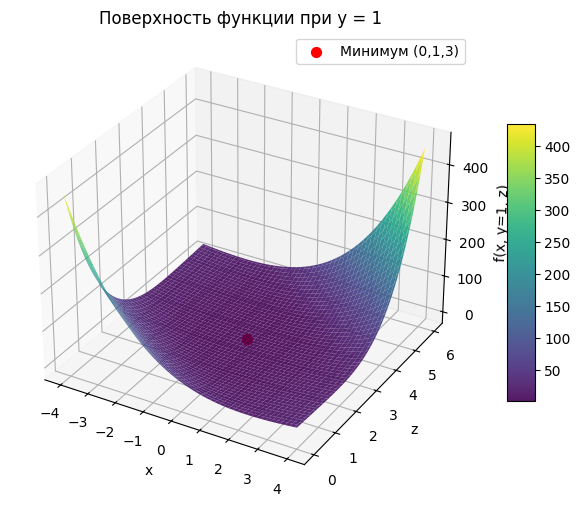

Аналитический минимум (по условию): x=0, y=1, z=3
f(аналитический) = 1.000000000000e+00

Координатный спуск
Найденная точка: x = -0.0076993108, y = 1.0000000175, z = 2.9866895873
f(x) = 1.0000000561e+00
Норма градиента = 2.908e-05
Итераций (внешних) = 200
Вызовов одномерного поиска = 25800, итераций в одномерном поиске = 24000
Наискорейший спуск
Найденная точка: x = -0.0111900404, y = 1.0000000000, z = 2.9806473982
f(x) = 1.0000002500e+00
Норма градиента = 5.334e-05
Итераций (внешних) = 200
Вызовов одномерного поиска = 8600, итераций в одномерном поиске = 8000
Метод Ньютона
Найденная точка: x = -0.0028700857, y = 1.0000000000, z = 2.9950288657
f(x) = 1.0000000011e+00
Норма градиента = 7.565e-07
Итераций (внешних) = 8

Сравнительная таблица:
             Метод          x*         y*         z*        f(x*)  ||grad||  Итерации
Координатный спуск -0.00769931 1.00000002 2.98668959 1.000000e+00 2.908e-05       200
Наискорейший спуск -0.01119004 1.00000000 2.98064740 1.000000e+00 5.334e-05  

In [48]:
def main():
    (x_min, y_min, z_min), f_min = analytical_solution_sympy()
    plot_function_surface()

    x0_shift = 0.0
    z0_shift = 3.0
    alpha = pi / 3.0

    func3d = TargetFunction(x0=x0_shift, z0=z0_shift, alpha=alpha)

    X0 = np.array([5.0, 5.0, 0.0])

    tol = 1e-6

    print("Аналитический минимум (по условию): x=0, y=1, z=3")
    analytic = np.array([0.0, 1.0, 3.0])
    print(f"f(аналитический) = {func3d.value(analytic):.12e}\n")

    cd_res = coordinate_descent(func3d, X0, tol=tol, max_iters=200, line_bracket=(-10,10))
    sd_res = steepest_descent(func3d, X0, tol=tol, max_iters=200, line_bracket=(-10,10))
    newt_res = newton_method(func3d, X0, tol=tol, max_iters=100)

    results = [cd_res, sd_res, newt_res]

    for r in results:
        xm = r['x_min']
        print("="*60)
        print(r['method'])
        print(f"Найденная точка: x = {xm[0]:.10f}, y = {xm[1]:.10f}, z = {xm[2]:.10f}")
        print(f"f(x) = {r['f_min']:.10e}")
        print(f"Норма градиента = {r['grad_norm']:.3e}")
        print(f"Итераций (внешних) = {r['iterations']}")
        if 'line_search_calls' in r:
            print(f"Вызовов одномерного поиска = {r['line_search_calls']}, итераций в одномерном поиске = {r['line_search_iters']}")
    print("="*60)

    data = []
    for r in results:
        xm = r['x_min']
        data.append({
            'Метод': r['method'],
            'x*': f"{xm[0]:.8f}",
            'y*': f"{xm[1]:.8f}",
            'z*': f"{xm[2]:.8f}",
            'f(x*)': f"{r['f_min']:.6e}",
            '||grad||': f"{r['grad_norm']:.3e}",
            'Итерации': r['iterations']
        })
    df = pd.DataFrame(data)
    print("\nСравнительная таблица:")
    print(df.to_string(index=False))

if __name__ == "__main__":
    main()